# Проект по Deep Learning: Sentiment Analysis c предобученной моделью

Задача проекта — с помощью transfer learning BERT'a получить модель для оценки тональности отзывов на различные авиакомпании. Изначально предполагалось использовать датасет из англоязычных твитов с меншнами авиакомпаний с тремя типами оценок — негативной, положительной и нейтральной, однако в процессе реализации обнаружилась ошибка, о которой подробнее напишу в итогах, и поэтому данные пришлось заменить на другие, в которых только два класса.

Из других работ по теме нашлись туториалы по transfer learning для оценки тональности от fast.ai (например https://docs.fast.ai/tutorial.text.html), показался интересным их формат данных, получающийся в результате препроцессинга – он добавляет новые служебные токены, например, для обозначения капитализации.

In [30]:
import os
import random
import re
import time
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda")

In [3]:
train_data = pd.read_csv('train_data.csv')

In [4]:
train_data.head()

,id,tweet,label
0,80938,@united I'm having issues. Yesterday I rebooke...,0
1,10959,@united kinda feel like the $6.99 you charge f...,0
2,130813,"Livid in Vegas, delayed, again&amp; again&amp;...",0
3,146589,@united the most annoying man on earth is on m...,0
4,117579,"@united The last 2 weeks I've flown wit u, you...",0


In [5]:
train_data['label'].value_counts()

1    1700
0    1700
Name: label, dtype: int64

In [6]:
test_data = pd.read_csv('test_data.csv')

In [7]:
test_data.head()

,Unnamed: 0,id,tid_not_to_be_used,airline,tag,tweet
0,1,33,506248858599710720,SouthWest,iL{o7e82\Uob,@SouthwestAir get your damn act together. Don'...
1,2,58,506259476341477376,American,iL{o7e82\Uob,@AmericanAir horrible at responding to emails....
2,3,135,506402253826428928,American,iL{o7e82\Uob,@AmericanAir hey where is your crew? Flight aa...
3,4,159,506438943454158848,United,iL{o7e82\Uob,Ok come on we are late let's goooo @united
4,5,182,506455754568904704,American,iL{o7e82\Uob,@AmericanAir since you are now affiliated with...


In [8]:
test_data = test_data[['id', 'tweet']]

In [9]:
test_data.head()

,id,tweet
0,33,@SouthwestAir get your damn act together. Don'...
1,58,@AmericanAir horrible at responding to emails....
2,135,@AmericanAir hey where is your crew? Flight aa...
3,159,Ok come on we are late let's goooo @united
4,182,@AmericanAir since you are now affiliated with...


In [10]:
len(test_data)

4555

# Baseline

В качестве бейзлайна попробуем tf-idf + логистическую регрессию.

In [16]:
def clean(text):
    
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [18]:
X = train_data.tweet.values
y = train_data.label.values

X_train, X_valid, y_train, y_valid =\
    train_test_split(X, y, test_size=0.1, random_state=234)

In [22]:
X_train_preprocessed = np.array([clean(text) for text in X_train])
X_valid_preprocessed = np.array([clean(text) for text in X_valid])

In [25]:
tfidf = TfidfVectorizer(ngram_range=(1, 3))

In [26]:
X_train_tfidf = tfidf.fit_transform(X_train_preprocessed)
X_valid_tfidf = tfidf.transform(X_valid_preprocessed)

In [29]:
def evaluate_chart(probs, y_true):

    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print('AUC: ', roc_auc)
    y_pred = np.where(preds >= 0.5, 1, 0)
    acc = accuracy_score(y_true, y_pred)
    print('Accuracy: ', acc)

    plt.plot(fpr, tpr, 'b')
    plt.plot()
    plt.ylabel('true positives ')
    plt.xlabel('false positives ')
    plt.show()

In [31]:
nb_model = LogisticRegression(random_state=234, max_iter=1000)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_valid_tfidf)

AUC:  0.8197748917748918
Accuracy:  0.7529411764705882


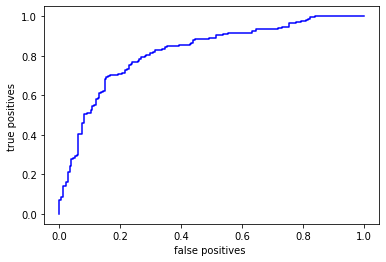

In [32]:
evaluate_chart(probs, y_valid)

# BERT

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [34]:
def prepare_for_bert(data):

    input_ids = list()
    attention_masks = list()

    for s in data:

        encoded = tokenizer.encode_plus(text=clean(s),
                                        add_special_tokens=True,        
                                        max_length=max_len, 
                                        pad_to_max_length=True, 
                                        return_attention_mask=True 
                                        )
        
        input_ids.append(encoded.get('input_ids'))
        attention_masks.append(encoded.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [35]:
all_data = np.concatenate([train_data.tweet.values, test_data.tweet.values])

In [36]:
data_encoded = [tokenizer.encode(s, add_special_tokens=True) for s in all_data]
max_len = max([len(s) for s in data_encoded])
print(max_len)

68


In [37]:
max_len = 64
batch_size = 32

In [38]:
train_inputs, train_masks = prepare_for_bert(X_train)
valid_inputs, valid_masks = prepare_for_bert(X_valid)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [39]:
train_labels = torch.tensor(y_train)
valid_labels = torch.tensor(y_valid)

In [40]:
train = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train)
train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)

valid = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid)
valid_dataloader = DataLoader(valid, sampler=valid_sampler, batch_size=batch_size)

In [41]:
class BertClassifier(torch.nn.Module):

    def __init__(self, freeze_bert=False):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.classifier = torch.nn.Sequential(torch.nn.Linear(768, 50),
                                                torch.nn.ReLU(),
                                                torch.nn.Linear(50, 2)
                                                )

        if freeze_bert:
            
            for param in self.bert.parameters():
                
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask
                           )
        
        last_hs = outputs[0][:, 0, :]
        res = self.classifier(last_hs)

        return res

In [42]:
def lang_model(n_epochs=2):

    bert_classifier = BertClassifier(freeze_bert=False)
    bert_classifier.to(device)
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,  
                      eps=1e-8  
                      )

    total_steps = len(train_dataloader)*n_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    return bert_classifier, optimizer, scheduler

In [43]:
loss_cel = torch.nn.CrossEntropyLoss()

In [44]:
def train_model(model, train_dataloader, val_dataloader=None, n_epochs=2, evaluation=False):

    for epoch in range(n_epochs):

        print('Epoch: ', epoch)

        total_loss = 0
        batch_loss = 0 
        batch_counts = 0

        model.train()

        for i, batch in enumerate(train_dataloader):
            
            batch_counts +=1
            input_ids, mask, labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(input_ids, mask)
            loss = loss_cel(logits, labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        loss_avg = total_loss / len(train_dataloader)

        print('Loss: ', loss_avg)
        
        if evaluation == True:

            valid_loss, valid_accuracy = evaluate(model, valid_dataloader)
            print('Evaluation')
            print('valid_loss: ', valid_loss)
    
    print("Training complete!")

In [45]:
def evaluate(model, valid_dataloader):

    model.eval()
    valid_loss = list()
    valid_acc = list()
    
    for i in valid_dataloader:
        
        input_ids, mask, labels = tuple(t.to(device) for t in i)

        with torch.no_grad():
            
            logits = model(input_ids, mask)

        loss = loss_cel(logits, labels)
        valid_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        acc = (preds == labels).cpu().numpy().mean()*100
        valid_acc.append(acc)

    valid_loss = np.mean(valid_loss)
    valid_accuracy = np.mean(valid_acc)

    return valid_loss, valid_acc

In [46]:
random.seed(234)
np.random.seed(234)
torch.manual_seed(234)
torch.cuda.manual_seed_all(234)

bert_classifier, optimizer, scheduler = lang_model(n_epochs=10)
train_model(bert_classifier, train_dataloader, valid_dataloader, n_epochs=10, evaluation=True)

Epoch:  0
Loss:  0.5425929799675941
Evaluation
valid_loss:  0.4561811008236625
Epoch:  1
Loss:  0.30389362045874196
Evaluation
valid_loss:  0.4575255540284244
Epoch:  2
Loss:  0.13721687434008345
Evaluation
valid_loss:  0.5970899218862707
Epoch:  3
Loss:  0.07663019511771078
Evaluation
valid_loss:  0.8320040757005865
Epoch:  4
Loss:  0.039442358756787144
Evaluation
valid_loss:  1.1285038915547458
Epoch:  5
Loss:  0.017609882019314682
Evaluation
valid_loss:  1.1372669501738115
Epoch:  6
Loss:  0.007967537039803574
Evaluation
valid_loss:  1.0703445049849423
Epoch:  7
Loss:  0.004641239739915666
Evaluation
valid_loss:  1.1517843360250646
Epoch:  8
Loss:  0.005498054769608037
Evaluation
valid_loss:  1.1090383367104963
Epoch:  9
Loss:  0.002252053226281229
Evaluation
valid_loss:  1.1405891532247716
Training complete!


In [47]:
def prediction(model, test_dataloader):

    model.eval()
    logits = list()

    for batch in test_dataloader:
        
        input_ids, mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logs = model(input_ids, mask)
            
        logits.append(logs)
    
    logits = torch.cat(logits, dim=0)
    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

    return probs

AUC:  0.8783203463203464
Accuracy:  0.7970588235294118


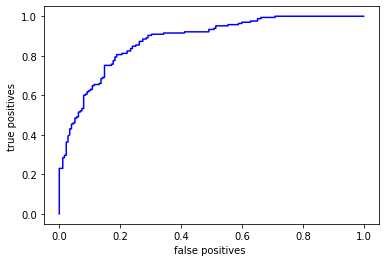

In [48]:
probs = prediction(bert_classifier, valid_dataloader)

evaluate_chart(probs, y_valid)

In [49]:
full_train = torch.utils.data.ConcatDataset([train, valid])
full_train_sampler = RandomSampler(full_train)
full_train_dataloader = DataLoader(full_train, sampler=full_train_sampler, batch_size=32)

In [50]:
bert_classifier, optimizer, scheduler = lang_model(n_epochs=10)
train_model(bert_classifier, full_train_dataloader, n_epochs=10)

Epoch:  0
Loss:  0.5430919764754928
Epoch:  1
Loss:  0.29742680190601084
Epoch:  2
Loss:  0.16739220758813006
Epoch:  3
Loss:  0.09816992349887842
Epoch:  4
Loss:  0.058301511847318334
Epoch:  5
Loss:  0.04117813908329634
Epoch:  6
Loss:  0.021417608323602753
Epoch:  7
Loss:  0.013281274036391177
Epoch:  8
Loss:  0.011258918097869398
Epoch:  9
Loss:  0.008665517481722843
Training complete!


In [51]:
test_inputs, test_masks = prepare_for_bert(test_data.tweet)
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [52]:
probs = prediction(bert_classifier, test_dataloader)
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

In [56]:
output = test_data[preds==1]
list(output.sample(10).tweet)

['@DeltaAssist can no longer login using email address, looking for assistance please',
 'We had the most amazing customer service from @LANAirlinesUSA when we flew to Peru. Today I had to talk to @JetBlue and ugh, back to reality',
 '@DeltaAssist can I switch to an earlier flight tomorrow at no cost?',
 "@gegrove @VirginAmerica Never flown them, but it's why I fly Jet Blue almost exclusively. Best customer service period.",
 'Back in #Chicago! Oh, how I have missed you... @ChooseChicago @enjoyillinois @AmericanAir #ttot #travel http://t.co/c1SYW42QfB',
 '_ @VirginAmerica _ Do you look better on the red carpet or the mechanical bull? Vote for your party...: Do you... http://t.co/5LTIu68ZZi',
 '@TommyFlanagan @AmericanAir hot all day long sweetheart! Tommy you stole my heart at Cape Fear Harley Davidson!',
 'After this weekend, @United Airlines could become the official carrier of @KJMacDonald in 2015. I already miss sleeping in first class. :-)',
 '@AmericanAir are all flights to Ord f

Видно, что наша модель справляется примерно на 7 процентов лучше бейзлайна. Судя по туториалам, которые находила в процессе подготовки, это далеко не предел возможностей, и более тщательным файнтюнингом можно добиться большего.
Из примеров твитов, характеризованных как положительные, видно, что некоторые твиты сложно однозначно характеризовать как позитивные или негативные, однако большинство из них все равно предсказаны верно.

Среди сложностей, с которыми столкнулась во время работы, хочется отметить проблему с данными, о которой писала ранее — ошибка RuntimeError: CUDA error: device-side assert triggered появлялась, когда лейблов было более чем два, а также не очень большое количество примеров использования transfer learning именно в отношении текстов, а не изображений. Зато в начале работы попробовала применить один из предложенных в таком туториале метод transfer learning для дообучения модели, тренированной на ImageNet, на датасетах с собаками и кошками и осами и пчелами. 